# Perform the Hello World example on a 2-qubit Bell State

## Step 1. Map the problem to a quantum-native format
In a quantum program, quantum circuits are the native format in which to represent quantum instructions, and operators represent the observables to be measured. When creating a circuit, you'll usually create a new QuantumCircuit object, then add instructions to it in sequence.

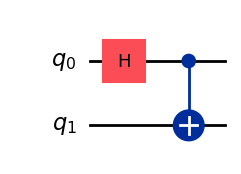

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [3]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

## Step 2. Optimize the circuits and operators

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture](https://docs.quantum.ibm.com/guides/transpile#instruction-set-architecture) (ISA) and must consider the device's basis gates and qubit connectivity.

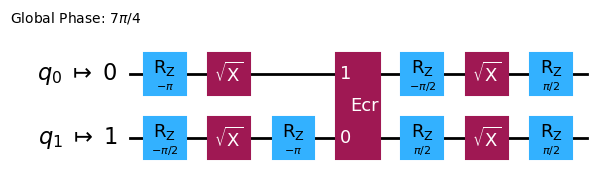

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
 
backend = service.backend(name='ibm_kyoto')
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)

## Step 3. Execute using the quantum primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the Estimator class. Estimator is one of two primitives; the other is Sampler, which can be used to get data from a quantum computer. These objects possess a run() method that executes the selection of circuits, observables, and parameters (if applicable), using what's known as a primitive unified bloc (PUB).

In [5]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
estimator = Estimator(backend=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cv8hvz78gpc0008gev20


In [6]:
# Make sure to run this portion after the job run completes
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

## Step 4. Analyze the results
The analyze step is typically where you might postprocess your results using, for example, measurement error mitigation or zero noise extrapolation (ZNE). You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem. For this example, plot each of the expectation values that were measured for our circuit.
The expectation values and standard deviations for the observables you specified to Estimator are accessed through the job result's PubResult.data.evs and PubResult.data.stds attributes.

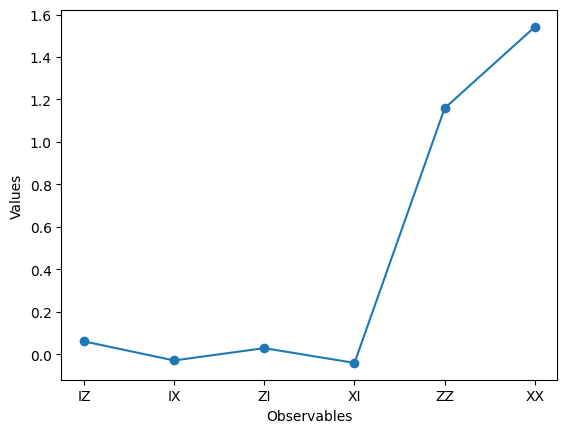

In [7]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()